In [1]:
## import libraries
import sys
import glob
import re

import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar


# cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap, plot_terrain
from utils import roundPartial, select_months_ds
import customcmaps as ccmap

pd.options.display.float_format = "{:,.2f}".format # makes it so pandas tables display only first two decimals

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## load continental divide shapefile
fp = path_to_data + 'downloads/continental_divide_shapefile/pw312bv3382.shp'
divide = gpd.read_file(fp, crs="ESPG:4326")

## load HU2 shapefile for regions 10, 11, 13, 14
region_lst = [10, 11, 13, 14]
WBD_lst = []
for i, region in enumerate(region_lst):
    fp = path_to_data + 'downloads/WBD_HU2_{0}/Shape/WBDHU2.shp'.format(region)
    WBD = gpd.read_file(fp, crs="ESPG:4326")
    WBD_lst.append(WBD)

## load watershed shapefile
## use geopandas to import the shapefile
fp = path_to_data + 'downloads/CO_HUC8/wbdhu8.shp'
polys = gpd.read_file(fp, crs="epsg:4326") # have to manually set the projection

In [4]:
# ## load Rutz AR
# print('Loading Rutz AR data')
# fname_pattern = path_to_data + 'preprocessed/MERRA2/MERRA2_Rutz_latlon_*.nc'
# ar = xr.open_mfdataset(fname_pattern)

# ## sum/count the values divide by total
# count_AR = ( ar.AR.sum(dim="time") / ar.time.shape ) *100
# count_AR = count_AR.compute()

# fname_out = path_to_data + 'MERRA2_Rutz_AR_count.nc'
# count_AR.to_netcdf(path=fname_out, mode = 'w', format='NETCDF4')

# ## load AR scale
# print('Loading ERA5 AR scale')
# fname_pattern = path_to_data + 'preprocessed/ARScale_ERA5/ERA5_ARScale_*.nc'
# arscale = xr.open_mfdataset(fname_pattern)

# arscale_new = xr.where((arscale['rank'] > 0.), 1, 0)
# ## sum/count the values divide by total
# count_arscale = (arscale_new.sum(dim="time") / arscale.time.shape ) *100
# count_arscale = count_arscale.compute()

# fname_out = path_to_data + 'ERA5_ARScale_count.nc'
# count_arscale.to_netcdf(path=fname_out, mode = 'w', format='NETCDF4')

# ## Load tARgetv4 AR data
# print('Loading tARgetv4')
# fname = path_to_data + 'preprocessed/tARgetv4/globalARcatalog_ERA5_2000-2023_v4.0.nc'
# tARgetv4 = xr.open_dataset(fname)

# tARget_new = xr.where((tARgetv4['kidmap'] > 0.), 1, 0)
# ## sum/count the values divide by total
# count_tARgetv4 = (tARget_new.sum(dim="time") / tARgetv4.time.shape ) *100
# count_tARgetv4 = count_tARgetv4.compute()

# fname_out = path_to_data + 'tARgetv4_count.nc'
# count_tARgetv4.to_netcdf(path=fname_out, mode = 'w', format='NETCDF4')

In [5]:
## load Rutz AR frequency data
fname = path_to_data + 'MERRA2_Rutz_AR_count.nc'
ar = xr.open_dataset(fname)

## load AR scale frequency data 
fname = path_to_data + 'ERA5_ARScale_count.nc'
arscale = xr.open_dataset(fname)

## Load tARgetv4 AR frequency data
fname = path_to_data + 'tARgetv4_count.nc'
tARgetv4 = xr.open_dataset(fname)

data_lst = [tARgetv4, arscale, ar]

In [17]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.PlateCarree() ## the projection you want your map displayed in

# Set tick/grid locations
ext1 = [-111., -100., 35.5, 42.5] # extent of CO
dx = np.arange(ext1[0],ext1[1]+2,2)
dy = np.arange(ext1[2]-.5,ext1[3]+1,1)
letter_lst = list(map(chr, range(97, 123)))
lbl_lst = ['tARgetv4', 'ERA5 AR Scale', 'Rutz AR']
varname_lst = ['kidmap', 'rank', 'AR']

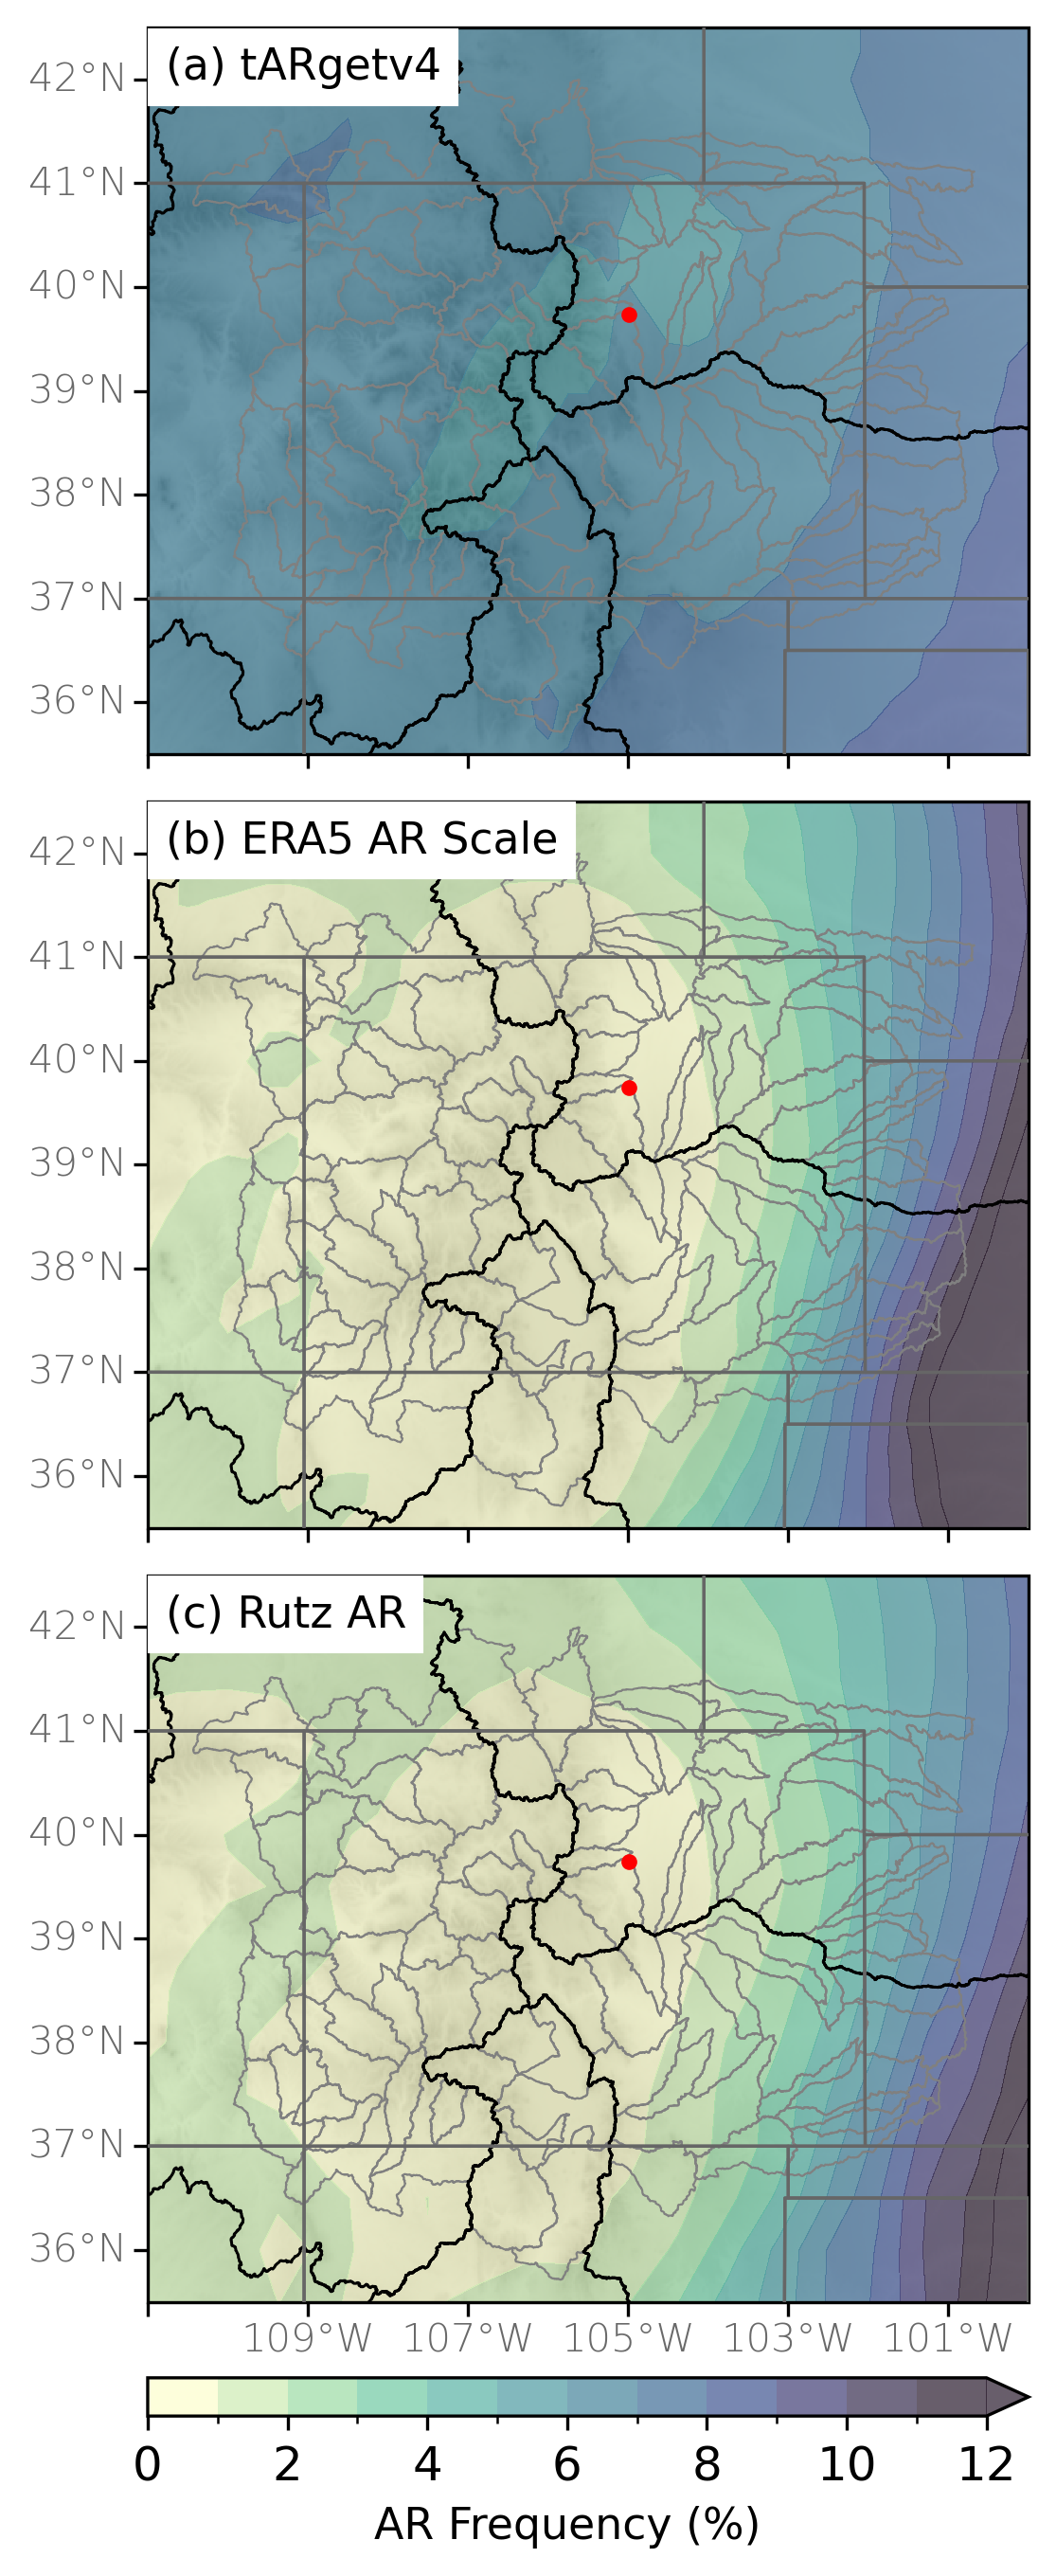

In [21]:
# Create figure
fig = plt.figure(figsize=(4, 11))
fig.dpi = 300
fname = path_to_figs + 'ar_freq_overhead'
fmt = 'png'

nrows = 5
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 0.05, 0.05], width_ratios = [1], wspace=0.02, hspace=0.02)
## use gs[rows index, columns index] to access grids

row_idx = [0, 1, 2]
b_lons = [False, False, True]

for k, data in enumerate(data_lst):
    ## Add axis for plot
    ax = fig.add_subplot(gs[row_idx[k],0], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext1, xticks=dx, yticks=dy,left_lats=True, right_lats=False, bottom_lons=b_lons[k], mask_ocean=False, coastline=False)

    ## topo with gray shading
    cs = plot_terrain(ax, ext1)

    # add choropleth watershed fraction
    cmap, norm, bnds = ccmap.cmap_segmented(cmo.deep, np.arange(0, 13, 1))
    cf = ax.contourf(data.lon.values, data.lat.values, data[varname_lst[k]].values, transform=datacrs,
                     levels=bnds, cmap=cmap, norm=norm, alpha=0.7, extend='max')

    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8, zorder=199)
    # Plot Location of pts
    ax.plot(-104.9903, 39.7392, 'ro', markersize=3, transform=datacrs, zorder=201)

    # ## add in four focus watersheds
    polys.plot(ax=ax, edgecolor='grey', color='None', linewidth=0.5, zorder=98)
    # tmp.plot(ax=ax, edgecolor='white', color='None', zorder=99)
    # # basin.plot(ax=ax, edgecolor='white', color='None', zorder=99)

    ## add in region watershed shape
    for j, WBD in enumerate(WBD_lst):
        WBD.plot(ax=ax, edgecolor='k', color='None', linewidth=0.7, zorder=100)

    # ## add continental divide
    # # divide.plot(ax=ax, color='tab:blue', zorder=99)

    # # ax.set_title(lbl_lst[k], loc='left', fontsize=14)
    # ax.text(-0.16, 0.5, lbl_lst[k], va='bottom', ha='center',
    #                 rotation='vertical', rotation_mode='anchor', fontsize=13,
    #                 transform=ax.transAxes)

    titlestring = '({0}) {1}'.format(letter_lst[k], lbl_lst[k])
    ax.text(0.02, 0.975, titlestring, ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

# Add color bar
cbax = plt.subplot(gs[-1,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('AR Frequency (%)', fontsize=11)
cb.ax.tick_params(labelsize=12)
        
fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()